In [34]:
# reload all libraries
%load_ext autoreload
%autoreload 2

import os
from PIL import Image
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image
import torchvision.transforms as transforms
from adv import (
    ResNet18Embedding,
    VAEEmbedding,
    ClipEmbedding,
    KLVAEEmbedding,
)
import argparse
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
# change torch cache 
os.environ['TORCH_HOME'] = '~/.cache_new'
from glob import glob
from glob import glob
EPS_FACTOR = 1 / 255
ALPHA_FACTOR = 0.05
N_STEPS = 200
BATCH_SIZE = 20

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
class WarmupPGDEmbedding:
    def __init__(
        self,
        model,
        device,
        eps=8 / 255,
        alpha=2 / 255,
        steps=10,
        loss_type="l2",
        random_start=True,
    ):
        self.model = model
        self.eps = eps
        self.alpha = alpha
        self.steps = steps
        self.loss_type = loss_type
        self.random_start = random_start
        self.device = device

        # Initialize the loss function
        if self.loss_type == "l1":
            self.loss_fn = torch.nn.L1Loss()
        elif self.loss_type == "l2":
            self.loss_fn = torch.nn.MSELoss()
        else:
            raise ValueError("Unsupported loss type")

    def forward(self, images, init_delta=None):
        self.model.eval()
        images = images.clone().detach().to(self.device)

        # Get the original embeddings
        original_embeddings = self.model(images).detach()
        # initialize adv images
        if self.random_start:
            adv_images = images.clone().detach()
            # Starting at a uniformly random point
            adv_images = adv_images + torch.empty_like(adv_images).uniform_(
                -self.eps, self.eps
            )
            adv_images = torch.clamp(adv_images, min=0, max=1).detach()

        elif init_delta is not None:
            clamped_delta = torch.clamp(init_delta, min=-self.eps, max=self.eps)
            adv_images = images.clone().detach() + clamped_delta
            adv_images = torch.clamp(adv_images, min=0, max=1).detach()
        else:
            assert False

        # PGD
        for _ in range(self.steps):
            self.model.zero_grad()
            adv_images.requires_grad = True
            adv_embeddings = self.model(adv_images)

            # Calculate loss
            cost = self.loss_fn(adv_embeddings, original_embeddings)

            # Update adversarial images
            grad = torch.autograd.grad(
                cost, adv_images, retain_graph=False, create_graph=False
            )[0]
            adv_images = adv_images.detach() + self.alpha * grad.sign()
            delta = torch.clamp(adv_images - images, min=-self.eps, max=self.eps)
            adv_images = torch.clamp(images + delta, min=0, max=1).detach()

        return adv_images

In [29]:
def adv_emb_attack(
    wm_img_path, encoder, strength, output_path, device=torch.device("cuda:0")
):
    # check if the file/directory paths exist
    os.makedirs(output_path, exist_ok=True)
    for path in [wm_img_path, output_path]:
        if not os.path.exists(path):
            raise FileNotFoundError(f"The path does not exist: {path}")

    # load embedding model
    if encoder == "resnet18":
        # we use last layer's state as the embedding
        embedding_model = ResNet18Embedding("last")
    elif encoder == "clip":
        embedding_model = ClipEmbedding()
    elif encoder == "klvae8":
        # same vae as used in generator
        embedding_model = VAEEmbedding("stabilityai/sd-vae-ft-mse")
    elif encoder == "sdxlvae":
        embedding_model = VAEEmbedding("stabilityai/sdxl-vae")
    elif encoder == "klvae16":
        embedding_model = VAEEmbedding("MudeHui/vae-f16-c16")
    else:
        raise ValueError(f"Unsupported encoder: {encoder}")
    embedding_model = embedding_model.to(device)
    embedding_model.eval()
    print("Embedding Model loaded!")

    # load data
    transform = transforms.ToTensor()
    wm_dataset = SimpleImageFolder(wm_img_path, transform=transform)
    wm_loader = DataLoader(
        wm_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True
    )
    print("Data loaded!")

    # Create an instance of the attack
    attack = WarmupPGDEmbedding(
        model=embedding_model,
        eps=EPS_FACTOR * strength,
        alpha=ALPHA_FACTOR * EPS_FACTOR * strength,
        steps=N_STEPS,
        device=device,
    )

    # Generate adversarial images
    for i, (images, image_paths) in enumerate(wm_loader):
        images = images.to(device)

        # PGD attack
        images_adv = attack.forward(images)
        # save images
        for img_adv, image_path in zip(images_adv, image_paths):
            save_path = os.path.join(output_path, os.path.basename(image_path))
            save_image(img_adv, save_path)
    print("Attack finished!")
    return


class SimpleImageFolder(Dataset):
    def __init__(self, root, transform=None, extensions=None):
        if extensions is None:
            extensions = [".jpg", ".jpeg", ".png"]
        self.root = root
        self.transform = transform
        self.extensions = extensions

        # Load filenames from the root
        self.filenames = [
            os.path.join(root, f)
            for f in os.listdir(root)
            if os.path.isfile(os.path.join(root, f))
            and os.path.splitext(f)[1].lower() in self.extensions
        ]

    def __getitem__(self, index):
        image_path = self.filenames[index]
        image = Image.open(image_path).convert("RGB")
        if self.transform is not None:
            image = self.transform(image)
        return image, image_path  # return image path to identify the image file later

    def __len__(self):
        return len(self.filenames)


In [ ]:
from tqdm import tqdm
for watermark in tqdm(['rivagan', 'stegastamp', 'trw']):
    for attack in ['klvae8', 'klvae16', 'resnet18', 'clip', 'sdxlvae']:
        adv_emb_attack(f'/ephemeral/tbakr/watermark-analysis/cache/test_dataset_{watermark}', attack, 4, f'/ephemeral/tbakr/watermark-analysis/attacked/adverserial/{watermark}/{attack}')


Embedding Model loaded!
Data loaded!
Attack finished!


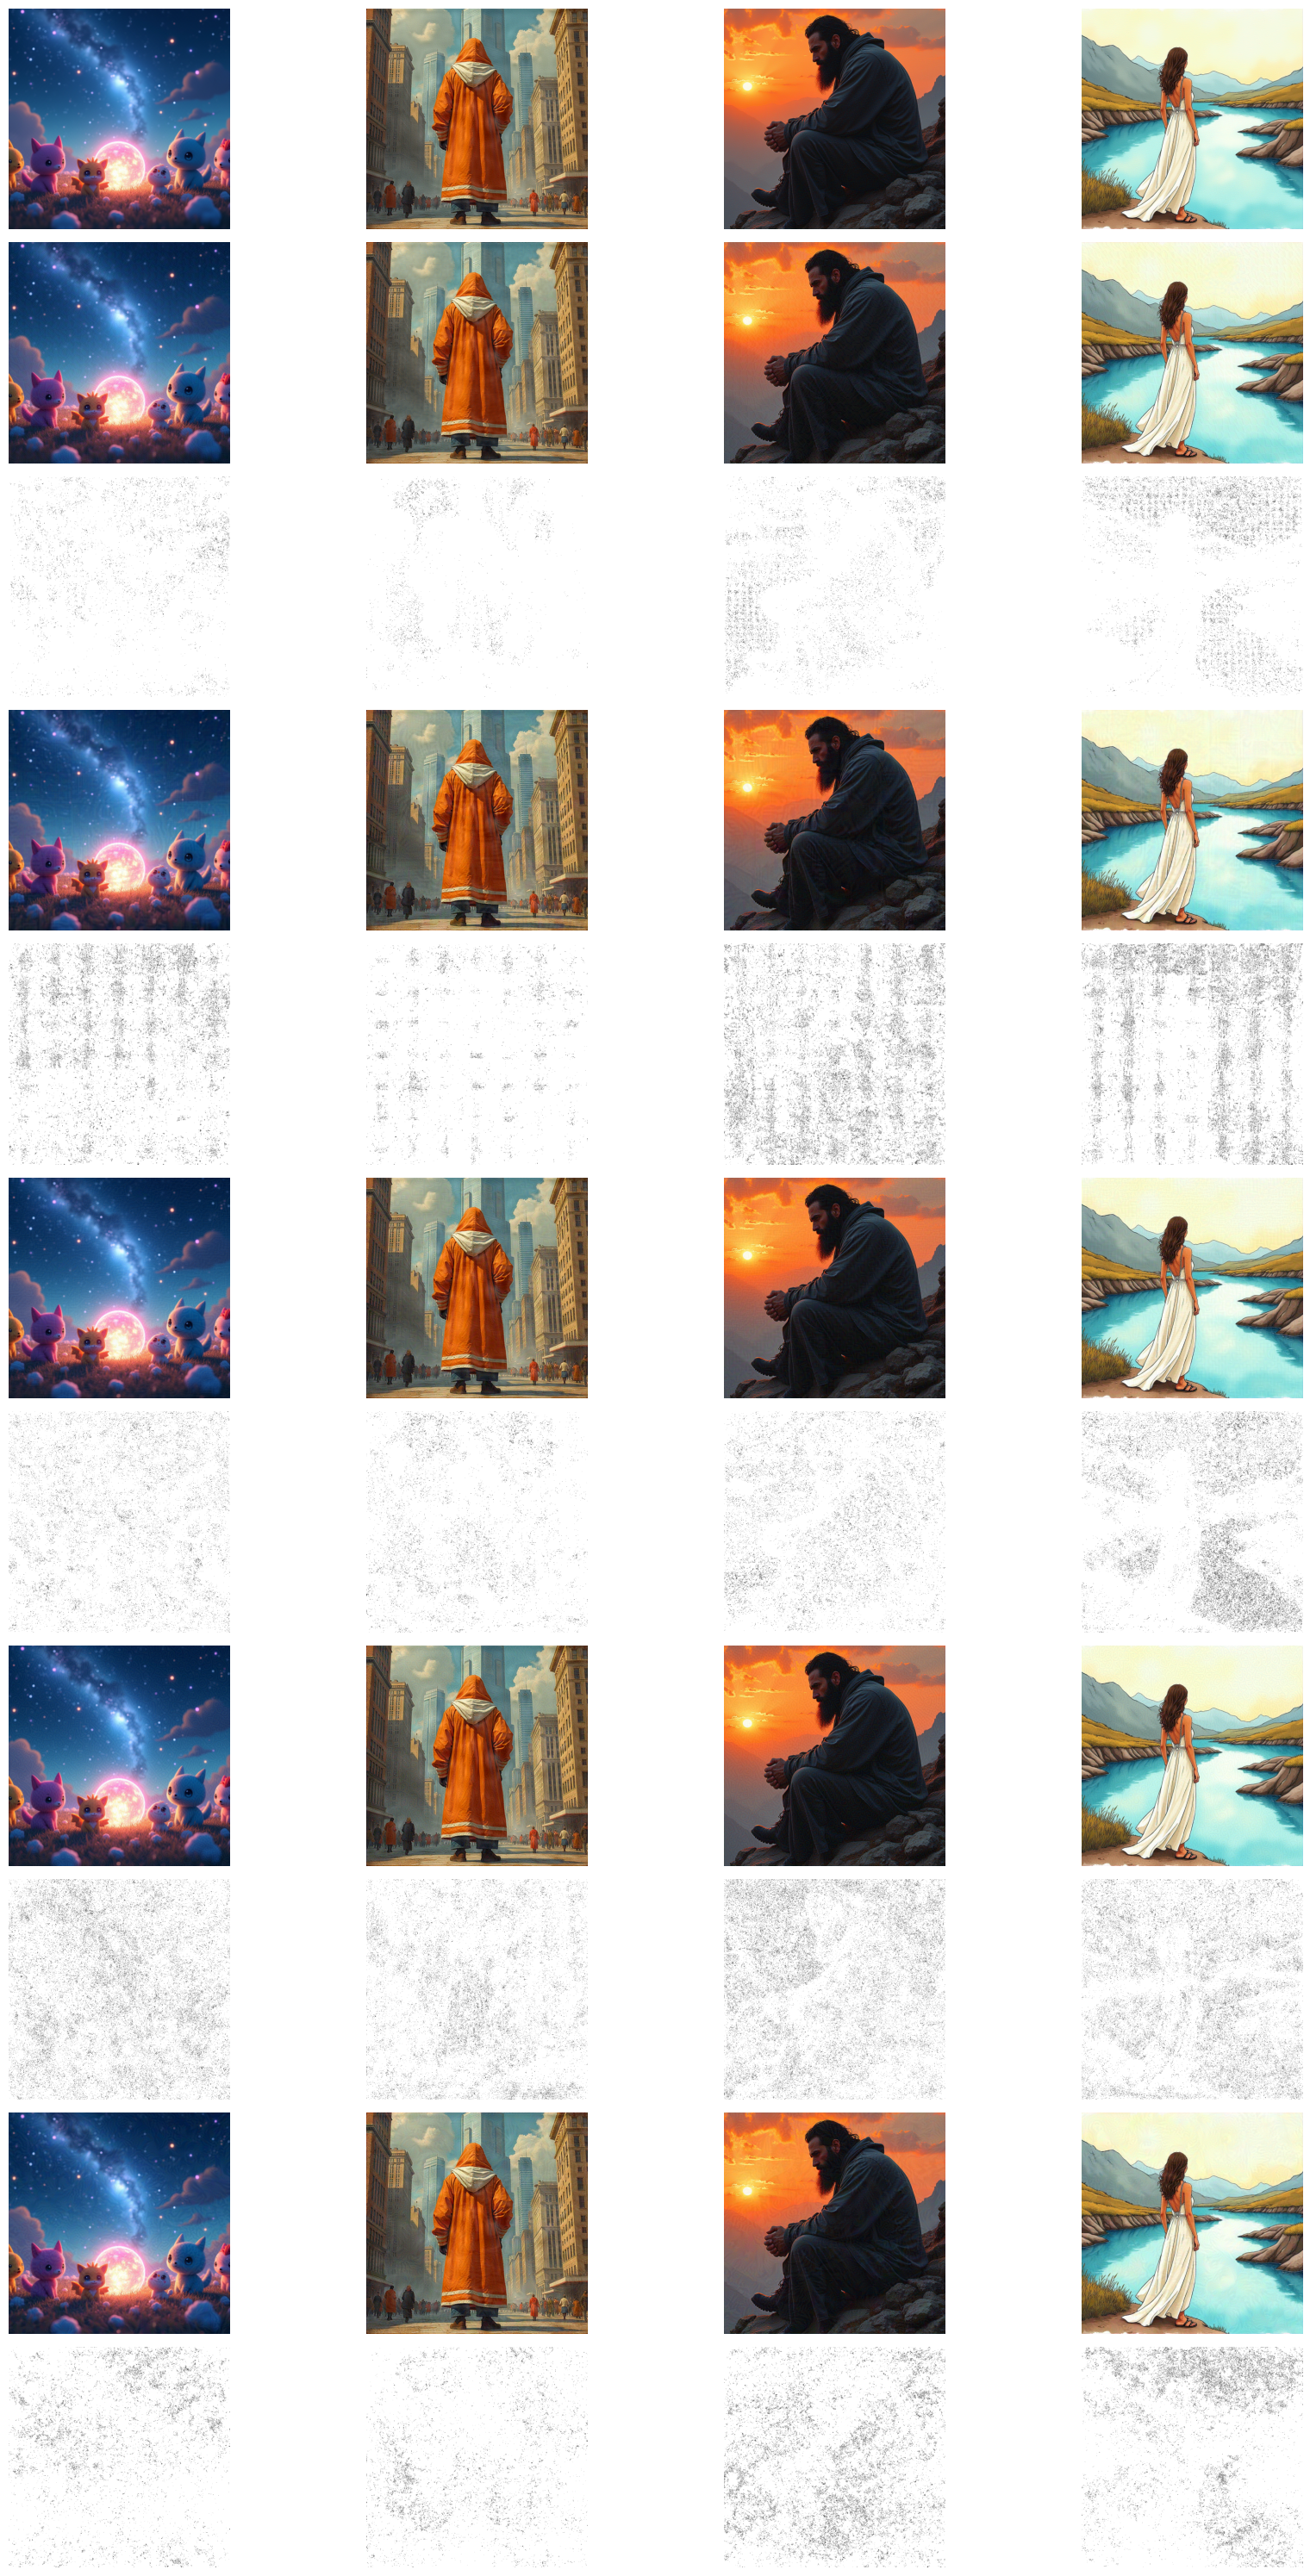

In [41]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

def load_images_from_dir(directory, indices):
    # Get the list of image paths in the directory and sort them
    images = sorted(glob(f'{directory}/*.png'), key=lambda x: int(os.path.basename(x).split('.')[0]))
    # Choose specified indices
    return [Image.open(images[i]).convert('RGB') for i in indices]

def compute_residuals(image_a, image_b):
    # Compute the absolute residuals between two images
    original_array = np.array(image_b, dtype=np.float32)
    model_array = np.array(image_a, dtype=np.float32)
    residual = np.abs(original_array - model_array)
    residual = residual.max(axis=-1)  # Take the max over the RGB channels
    # Normalize the residual for visualization
    residual_normalized = (255 * (residual - residual.min()) / (residual.max() - residual.min())).astype(np.uint8)
    return residual_normalized

def show_images_and_residuals(dir_a, dir_b, dir_c, dir_d, dir_e, dir_f, num_images=4):
    # Choose 4 random indices for image selection
    indices = random.sample(range(len(glob(f'{dir_a}/*.png'))), num_images)

    # Load images from each directory
    images_a = load_images_from_dir(dir_a, indices)
    images_b = load_images_from_dir(dir_b, indices)
    images_c = load_images_from_dir(dir_c, indices)
    images_d = load_images_from_dir(dir_d, indices)
    images_e = load_images_from_dir(dir_e, indices)
    images_f = load_images_from_dir(dir_f, indices)

    fig, axs = plt.subplots(11, 4, figsize=(18, 30))

    # Plot images and residuals for each directory
    for i in range(num_images):
        # Plot original images
        axs[0, i].imshow(images_a[i])
        axs[0, i].axis('off')

        # plot image_b
        axs[1, i].imshow(images_b[i])
        axs[1, i].axis('off')
        
        # Plot residuals for directory b vs directory a
        residual_b_a = compute_residuals(images_a[i], images_b[i])
        axs[2, i].imshow(residual_b_a, cmap='gray')
        axs[2, i].axis('off')

          # plot image_b
        axs[3, i].imshow(images_c[i])
        axs[3, i].axis('off')
        
        # Plot residuals for directory b vs directory a
        residual_c_a = compute_residuals(images_a[i], images_c[i])
        axs[4, i].imshow(residual_c_a, cmap='gray')
        axs[4, i].axis('off')

        axs[5, i].imshow(images_d[i])
        axs[5, i].axis('off')
        
        # Plot residuals for directory b vs directory a
        residual_d_a = compute_residuals(images_a[i], images_d[i])
        axs[6, i].imshow(residual_d_a, cmap='gray')
        axs[6, i].axis('off')

          # plot image_b
        axs[7, i].imshow(images_e[i])
        axs[7, i].axis('off')
        
        # Plot residuals for directory b vs directory a
        residual_e_a = compute_residuals(images_a[i], images_e[i])
        axs[8, i].imshow(residual_e_a, cmap='gray')
        axs[8, i].axis('off')
        # plot image_b
        axs[9, i].imshow(images_f[i])
        axs[9, i].axis('off')
        
        # Plot residuals for directory b vs directory a
        residual_f_a = compute_residuals(images_a[i], images_f[i])
        axs[10, i].imshow(residual_f_a, cmap='gray')
        axs[10, i].axis('off')


    plt.tight_layout()
    plt.show()

# Example usage
dir_a = '/ephemeral/yaya/projects/watermark-analysis/data/sample'
dir_b = '/ephemeral/yaya/projects/watermark-analysis/data/out'
dir_c = '/ephemeral/yaya/projects/watermark-analysis/data/clip'
dir_d = '/ephemeral/yaya/projects/watermark-analysis/data/klvae8'
dir_e = '/ephemeral/yaya/projects/watermark-analysis/data/sdxvae'
dir_f = '/ephemeral/yaya/projects/watermark-analysis/data/resnet18'

show_images_and_residuals(dir_a, dir_b, dir_c, dir_d, dir_e, dir_f)
